<a href="https://colab.research.google.com/github/NunezKant/COVID-19_GDL/blob/master/Desarrollo_de_COVID_19_en_Guadalajara_Miguel_N%C3%BA%C3%B1ez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Esta celda importa librerías que necesitaremos { display-mode: "form" }
%matplotlib inline
!pip install arviz
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import arviz as az
import pymc3 as pm
import altair as alt
import plotly.express as px
import requests
import io

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

<h1><center> Desarrollo de COVID - 19 en México </center></h1>

#Contexto

Hola! Me alegra que estés aquí, juntos vamos a aprender un poco sobre modelaje epidemiólogico y la situación del COVID-19 en México.

Mi nombre es Miguel Angel Núñez Ochoa, soy estudiante de doctorado en Neurociencias, y de un micromaster en estadística y ciencia de datos, formo parte de DataLab Community como mentor en ciencia de datos, y he sido profesor en la escuela de verano de la RIIAA. 

No soy experto en el área de epidemiología, pero tendrán las referencias de dónde estoy sacando los parámetros, o los modelos.

La motivación para hacer esto es por la desinformación que ronda en redes sociales y el poco contenido en español, esta es una libreta interactiva, la plataforma se llama Google Colab, este tipo de libreta nos permite escribir texto como el que estás viendo, intercalado con código, al lado de las celdas verán un simbolo de play, en caso de ser una celda de código, al darle click, ejecutan el codigo dentro de esa celda.

**Cualquier error u observación hagánmela saber**

Primero nos centraremos en entender el modelado epidemiológico de enfermedades, visitaremos algunos conceptos claves y veremos que nos pueden decir los modelos, trataré de hacer lo más digerible posible las partes que involucren muchas matemáticas.

---
#Introducción al modelo SEIR

El modelo con el cuál vamos a trabajar es conocido como **SEIR** y la implementación que hice está basada en el libro:
 * *Modeling Infectious Diseases in humans and animals (Keeling and Rohani, 2008)* 

Este modelo es uno de los modelos epidemiológicos más sencillos, se llama así por sus siglas,que hacen referencia a la capacidad del portador para transmitir la enfermedad:

* **S**uceptible: Persona aún no expuesta al patógeno, pero forma parte de una población que ya tiene expuestos.

* **E**xpuesto: Aquellas personas que están infectados pero aun no son *infecciosos*
 * Estas personas ya tienen el virus, pero el virus se encuentra en una etapa de desarrollo en el cuerpo, la carga viral es tán poca que la transmisión activa del virus es poco probable.
* **I**nfectados: Personas colonizadas por el patógeno
* **R**ecuperados: Aquellos que ya resolvieron la enfermedad.

>>>>![SEIR](https://drive.google.com/uc?id=16GNLZ5a8zZctmzWjMECjKrUZ4Zn4hwwQ)

---
#MATHBOX
<h2><center>¿Cómo modelamos esto?</center></h2>

Al ser un sistema dinámico, evoluciona con el tiempo, este tipo de sistemas se modelan con ecuaciones diferenciales, en el caso específico del modelo **SEIR** las ecuaciones son las siguientes:

\begin{gather*} 
\dot{S} =  - \beta SI \\ 
\dot{E} =  \beta SI - \alpha E \\
\dot{I} =  - \alpha E - \gamma I \\ 
\dot{R} =  \gamma I \\
S+E+I+R = 1
\end{gather*}

1. La primera ecuación describe el cambio en personas suceptibles
 * $\beta\$ es el nombre que le daremos a la **tasa promedio de contagio**

<font color='red'>FACT:</font> el distanciamiento social y la cuarentena son inversamente proporcinales a $\beta\$, es decir:

<center> "Al aumentar el distanciamento social, disminuimos la tasa promedio de contagio, por que reducimos el número de individuos infectados que se están mezclando de manera libre en la población" </center>

2. La segunda ecuación describe a las personas expuestas:
 * $\alpha$ es el **inverso del periodo de incubación**
 * Según (Laurer et al. 2020; Hellewell et al. 2020) el periodo de incubación para COVID-19 es de alrededor de **5 dias**, por lo tanto:
  * $\alpha = 1 / 5 \rightarrow 0.2$

3. La tercera ecuación modela el cambio en personas infectadas, basada en la gente expuesta (aquellas infectadas pero que aun no son *infecciosas*) y el tiempo promedio de capacidad infecciosa, es decir, cuantas personas expuestas hay y cuanto tiempo cargan la capacidad de infectar.
 * $\gamma$ es el inverso del **tiempo promedio de capacidad infecciosa**

4. La cuarta ecuación modela a los recuperados.

# Paréntesis: ¿Han escuchado el término $R_0$?

Este término se vuelve muy popular en tiempos de crisis epidemiológicas, también llamado **tasa básica de reproducción** se define formalmente como:

<center> "el número promedio de casos secundarios que tienen lugar a partir de un caso primario en una población suceptible" </center>

Y está dada por dos cantidades que ya conocemos $\beta$ y $\gamma$:

\begin{gather*} 
R_0 = \frac{\beta}{\gamma}
\end{gather*}

Conocer esta ecuación nos ayudará a encontrar $\beta$:
 * De (Peng et al. 2020) podemos tomar el estimado de $\gamma$ para COVID-19: $0.5$
 * De (Hellewell et al. 2020) podemos tomar el estimado de $R_0$ del COVID-19:
 $3.5$

Sustituyendo obtenemos que $\beta$ es $\sim 1.8$ 

*Algo a tener en cuenta es que este modelo asume una **población fija** es decir, no toma en cuenta nacimientos ni muertes, en el mejor de los casos podemos interpretar como que los decesos se acumulan en las personas "recuperadas" por que ya no pueden transmitir la enfermedad.*

---

<h1><center>Caso especifíco de Jalisco México</center></h1>

(22/03/2020)

Vamos a usar este modelo para ejemplificar la situación del estado de Jalisco, la cual:

* Tiene una población ($N$) de $\sim$ 8,000,000 habitantes.
* Tiene un total de 32 infectados ($I$)
* Asumiremos que como **mínimo** esas 32 personas han expuesto a 4 más (familias de 4 personas)
* Haremos la evaluación de la evolución de la enfermedad por 90 días.

In [0]:
dias_evaluacion = 90 #asumimos 90 días
dt = 1
periodo_evaluacion = np.linspace(0, dias_evaluacion, dias_evaluacion + 1)

alpha = 0.2
beta = 1.75
gamma = 0.5
parametros = alpha, beta, gamma

#Condiciones iniciales de la ZMG
JAL_Population = 8000000 
I_o = 32 / JAL_Population  # Tenemos 32 casos
E_o = (32*4)/JAL_Population # Asumimos 4 expuestos por caso
S_o = (1) - (E_o+I_o) # El resto somos suceptibles
R_o = 0 # NO hay ningun recuperado

Condiciones_Iniciales = S_o,E_o,I_o,R_o

In [0]:
def SEIR(IC,pmtrs,t,theta=1):
  """
  Esta parte de código es la que implementa las ecuaciones diferenciales.

  Se resuelven por medio de integración númerica de Euler
  """
  
  So,Eo,Io,Ro = IC
  S,E,I,R = [So],[Eo],[Io],[Ro]
  alpha,beta,gamma = pmtrs
  dt = t[1]-t[0]
  for _ in t[1:]:
    St = S[-1] - (theta*beta*S[-1]*I[-1])*dt
    Et = E[-1] + (theta*beta*S[-1]*I[-1] - alpha*E[-1])*dt
    It = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
    Rt = R[-1] + (gamma*I[-1])*dt
    S.append(St)
    E.append(Et)
    I.append(It)
    R.append(Rt)
  return S,E,I,R

In [0]:
S,E,I,R = SEIR(Condiciones_Iniciales,parametros,periodo_evaluacion) # Obtenemos los suceptibles, expuestos, infectados y recuperados para los proximos 90 dias

In [5]:
#@title Esta Celda grafica los resultados { display-mode: "form" }

E_a = np.array(E)*JAL_Population
I_a = np.array(I)*JAL_Population
Clase = np.array(["Expuestos"]*np.array(E).shape[0] + ["Infectados"]*np.array(E).shape[0])
Dias = np.concatenate([np.arange(0,91,1),np.arange(0,91,1)])
SEIR_df = pd.DataFrame({
    "Casos": np.concatenate([E_a,I_a]),
    "Clase": Clase,
    "Dias" : Dias
})

fig = px.line(SEIR_df, x="Dias", y="Casos", color='Clase')

fig.update_layout(
    title="Predicción del modelo SEIR de la evolución de COVID-19 en Guadalajara, Mexico",
    xaxis_title="Días",
    yaxis_title="Casos Totales",
    )

for trace in fig.data:
    trace.name = trace.name.split('=')[1]

fig.show()

El dia 0 es hoy 22/03/2020, si se quiere correr el análisis después habrá que cambiar las condiciones inciales (actualizar en número de infectados reportados)

# ¿Cómo saber cuando actuar?

Para tratar de responder esto, ajustaré una recta a los primeros 21 días, después, buscaré el punto de inflexión de los residuos de esa linea (qué sería igual a buscar el día en que el comportamiento lineal se perdío).

In [6]:
#@title Ajuste de la linea

import statsmodels.api as sm

X = SEIR_df["Dias"][:21].values
y = SEIR_df["Casos"][SEIR_df["Clase"]=="Infectados"][:21].values

model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.794
Model:                            OLS   Adj. R-squared (uncentered):              0.784
Method:                 Least Squares   F-statistic:                              77.08
Date:                Mon, 23 Mar 2020   Prob (F-statistic):                    2.69e-08
Time:                        19:57:23   Log-Likelihood:                         -162.27
No. Observations:                  21   AIC:                                      326.5
Df Residuals:                      20   BIC:                                      327.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Text(0.5, 1.0, 'El punto de inflexión es al día: 11 ')

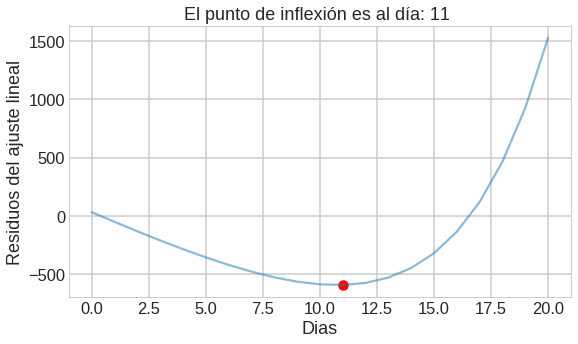

In [7]:
#@title ¿En donde empieza a equivocarse más la recta?

plt.figure(figsize=(9,5))
plt.plot(results.resid, alpha = 0.5)
plt.scatter(np.argmin(results.resid),np.min(results.resid),c = "r")
plt.ylabel("Residuos del ajuste lineal")
plt.xlabel("Dias")
dia = np.argmin(results.resid)
plt.title(f"El punto de inflexión es al día: {dia} ")

Es probable que el día crítico suceda en 11 días, que será cúando el comportamiento lineal empieza a subestimar los casos.

Ese día a día de hoy sería alrededor del 2 al 3 de abril, así que por favor:

<h1><center>QUEDENSE EN SU CASA</center></h1>
<h1><center>NI PENSAR EN VACACIONES!</center></h1>

Si tomamos en cuenta el día que se estima el pico máximo de casos (Día 50), y el día de inflexión (día 11) el modelo calcula 39 días de contigencia, lo equivalente a $\sim 6$ semanas aproximadamente.

Por lo que la contención debería estar pensada como mínimo que vaya de entre <font color='red'>3-7 semanas</font> lo que concuerda con recomendaciones internacionales, dado que esta estimación no toma en cuenta el efecto del aislamiento social.

Por otro lado, para observar el efecto del aislamiento y distanciamiento social, para los que observaron la parte del código de las ecuaciones diferenciales:

```
    St = S[-1] - (theta*beta*S[-1]*I[-1])*dt
    Et = E[-1] + (theta*beta*S[-1]*I[-1] - alpha*E[-1])*dt
```

A las ecuaciones de **S**uceptibles y **E**xpuestos, les agregué un parámetro que afecta a $\beta$ en este caso lo llamé $\theta$, este parámetro simula la proporcion de gente que atiende la cuarentena (**DISTANCIAMIENTO**).

$\theta = 0 \rightarrow$ supone que todos hacemos caso absoluto a la cuarentena

$\theta = 1 \rightarrow$ supone que todos hacemos caso omiso a la cuarentena

La ecuación modificada quedaría de la siguiente forma:


\begin{gather*} 
\dot{S} =  - \theta \beta SI \\ 
\dot{E} = \theta \beta SI - \alpha E \\
\end{gather*}





In [12]:
#@title AISLAMIENTO SOCIAL VS CASO OMISO (Interactivo!)



import plotly.graph_objects as go
fig = go.Figure()

for step in np.round(np.arange(0, 1.1, 0.1),1):
  S,E,I,R = SEIR(Condiciones_Iniciales,parametros,periodo_evaluacion,1-step)
  fig.add_trace(
        go.Scatter(
            visible=False,
            showlegend = True,
            line=dict(color="#DE1738", width=2),
            name="Infectados",
            x=np.arange(0, 91, 1),
            y=np.array(I)*JAL_Population)
        )
  

fig.data[0].visible = True

steps = []
labels = np.round(np.arange(1.0, -0.1, -0.1),1).tolist()
labels[0] = "Caso Omiso"
labels[10] = "Aislamiento Total"
for i in range(len(fig.data)):
    step = dict(
        method="restyle",
        args=["visible", [False] * len(fig.data)],
        label = str(labels[i])
    )
    step["args"][1][i] = True  
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Distanciamiento (Theta): "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    title="Predicción del modelo SEIR de la evolución de COVID-19 en Jalisco, Mexico",
    xaxis_title="Días",
    yaxis_title="Infectados Totales",
)

fig.show()

Como podemos ver el atender las recomendaciones de salubridad, lavarnos las manos, salir de casa exclusivamente por cuestiones prioritarias como una emergencia, salir por víveres o medicamentos, es una forma efectiva de aplanar la curva de infectados, descargar hospitales y poner al menor número de personas en riesgo.

Hay que atender las recomendaciones! <3 

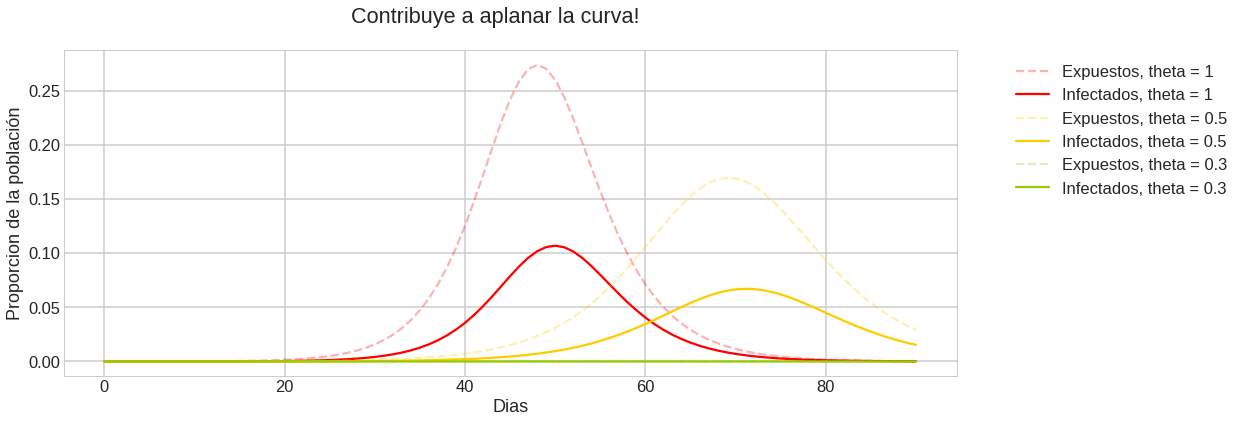

In [11]:
#@title QUEDATE EN CASA { display-mode: "form" }

periodo_evaluacion = np.linspace(0, 90, dias_evaluacion + 1)
_,E_1,I_1,_ = SEIR(Condiciones_Iniciales,parametros,periodo_evaluacion)
_,E_5,I_5,_ = SEIR(Condiciones_Iniciales,parametros,periodo_evaluacion,0.7)
_,E_3,I_3,_ = SEIR(Condiciones_Iniciales,parametros,periodo_evaluacion,0.3)
plt.figure(figsize= (16,6))
plt.suptitle("Contribuye a aplanar la curva!")
plt.plot(E_1,label = "Expuestos, theta = 1", ls = "--",alpha=0.3,c="#FF0000")
plt.plot(I_1,label = "Infectados, theta = 1",c="#FF0000")
plt.plot(E_5,label = "Expuestos, theta = 0.5", ls = "--",alpha=0.3,c="#FFCC00")
plt.plot(I_5,label = "Infectados, theta = 0.5",c="#FFCC00")
plt.plot(E_3,label = "Expuestos, theta = 0.3", ls = "--",alpha=0.3,c="#99CC00")
plt.plot(I_3,label = "Infectados, theta = 0.3",c="#99CC00")
plt.ylabel("Proporcion de la población")
plt.xlabel("Dias")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')